In [3]:
import pandas as pd
import os
import gzip
import requests

import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt

In [1]:
def get_elevation(lat, lng):
    url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lng}"
    response = requests.get(url)
    data = response.json()
    if 'results' in data and data['results']:
        return data['results'][0]['elevation']
    else:
        return None


In [4]:
elev = get_elevation(21.3866284869, -157.905641308)
print("Elevation:", elev, "meters")

Elevation: 198.0 meters


In [5]:
def data_import_bases(states = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]):

    """
    Returns a cleaned dataframe with all the military installations.

            Parameters:
                        states (list): list of states you want to see bases off

            Data:
                        https://public.opendatasoft.com/explore/dataset/military-bases/export/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6Im1pbGl0YXJ5LWJhc2VzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJvYmplY3RpZF8xIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0ZGNTE1QSJ9XSwieEF4aXMiOiJjb21wb25lbnQiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D&location=6,37.78808,-111.09375&basemap=jawg.light

            Returns:
                        bases_df (DataFrame): 
    """

    # Choose columns we need
    data_columns = ['Geo Point', 'COMPONENT', 'Site Name', 'State Terr', 'Oper Stat']

    # read in alle the military bases - seperator ';'
    bases_df = pd.read_csv('./data/military-bases.csv', sep=';', usecols = data_columns )

    # rename columns for easier use
    bases_df.rename(columns={'Geo Point': 'geoPoint', 'COMPONENT': "component", 'Site Name': 'name', 'State Terr': 'state', 'Oper Stat': 'status'}, inplace = True)

    # checking it there is only Active and Inaktive
    #bases_df[(bases_df.status != 'Active') & (bases_df.status != 'Inactive')]

    # drop all Inaktive bases
    bases_df = bases_df[bases_df.status != 'Inactive']

    # convert geo points
    bases_df[['lat', 'lon']] = bases_df.geoPoint.str.split(',', expand = True).astype('float64')
    bases_df.geoPoint = list(zip(bases_df.lat, bases_df.lon))
    bases_df.drop(columns = ['lat', 'lon'], inplace =  True)

    # filter by list of states
    bases_df = bases_df[bases_df.state.isin(states)]

    # get elevation for each location
    # need to be improved with POST request
    bases_df['elevation'] = bases_df['geoPoint'].apply(lambda point: get_elevation(point[0], point[1]))

    return bases_df

In [6]:
def data_import_tidel_sensors():

    """
    Returns a dictonary with the information about the sensor and the data.

            Parameters:
                        None

            Returns:
                        sensors (dict): dictionary consisting out of:

                            Info    (dict): Metadata of the Sensor

                                e.g.
                                NOS ID: 9410170
                                Location Name: SAN DIEGO, SAN DIEGO BAY
                                Latitude: 32.71419
                                Longitude: -117.17358
                                Horizontal Datum: WGS-84
                                Operator: DOC>NOAA>NOS>CO-OPS
                                Vertical Datum: Station Datum

                            Data    (dict): Data the sensor collected

            Source:
                        https://www.ngdc.noaa.gov/hazard/tide/

    """
    sensor_information_dict = dict()
    csv_header = list()
    sensor_data_df = pd.DataFrame()

    for idx, file in enumerate(os.listdir('./data/tide_sensors/.')):

        with gzip.open('./data/tide_sensors/' + file, 'rt') as file_in:
            
            # Reading in header
            sensor_information_file = file_in.readlines()[0:10]

        if len(csv_header) == 0:
            # Retrieving the header for csv
            csv_header = sensor_information_file[-1].removeprefix('// ').removesuffix('\n').split(',')
            csv_header = [item.strip() for item in csv_header]

        # Getting metadata for the sensor
        for line in sensor_information_file[:-4]:
            
            name, value = line.removeprefix('// ').strip().split(':')

            if name in sensor_information_dict:
                sensor_information_dict[name].append(value)
            else :
                sensor_information_dict[name] = [value]
        
        sensor_data_df_temp = pd.read_csv('./data/tide_sensors/' + file, skiprows=10, sep='\t', header=None, usecols=[0,1])
        sensor_data_df_temp.columns = csv_header[:2]
        sensor_data_df_temp['NOS ID'] = int(sensor_information_dict.get('NOS ID')[idx])
        sensor_data_df_temp['datetime [ISO8601]'] = pd.to_datetime(sensor_data_df_temp['datetime [ISO8601]'], format='ISO8601')
        sensor_data_df = pd.concat([sensor_data_df, sensor_data_df_temp])

    # Creating a df from the metadata
    sensor_information_df = pd.DataFrame(sensor_information_dict)

    sensor_information_df = sensor_information_df.assign(geoPoint = list(zip(sensor_information_df.Latitude.astype('float64'), sensor_information_df.Longitude.astype('float64'))))
    sensor_information_df.drop(columns = ['Latitude', 'Longitude'], inplace =  True)

    return sensor_information_df, sensor_data_df  

In [7]:
def curate_tide_sensor_data(tide_sensor_df):

    """
    Curates the tide sonsor data.

            Parameters:
                        tide_sensor_df (DataFrame): Contains all read in tide sensors

            Returns:
                        curated_tide_sensor_df 
    """

    # Remove all rows with 9999
    tide_sensor_df = tide_sensor_df[tide_sensor_df['waterlevel_quality_controlled [m]'] != 9999]
    # find unique sensors IDs
    tide_sensors = tide_sensor_df['NOS ID'].unique()

    # Group by NOS ID and month
    curated_tide_sensor_mean_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].mean()
    curated_tide_sensor_min_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].min()
    curated_tide_sensor_max_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].max()

    # Reset index
    curated_tide_sensor_mean_df = curated_tide_sensor_mean_df.reset_index()
    curated_tide_sensor_min_df = curated_tide_sensor_min_df.reset_index()
    curated_tide_sensor_max_df = curated_tide_sensor_max_df.reset_index()


    for sensor in tide_sensors:

        # Get the sensor data
        sensor_data = curated_tide_sensor_mean_df[curated_tide_sensor_mean_df['NOS ID'] == sensor]

        # Get the min and max
        sensor_data_min = curated_tide_sensor_min_df[curated_tide_sensor_min_df['NOS ID'] == sensor]
        sensor_data_max = curated_tide_sensor_max_df[curated_tide_sensor_max_df['NOS ID'] == sensor]

        # Merge the data
        sensor_data = sensor_data.merge(sensor_data_min[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')
        sensor_data = sensor_data.merge(sensor_data_max[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')

        # Rename columns
        sensor_data.columns = ['NOS ID', 'datetime', 'mean', 'min', 'max']

        # Plotting min, mean, and max
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(sensor_data['datetime'], sensor_data['min'], label='Min')
        ax.plot(sensor_data['datetime'], sensor_data['mean'], label='Mean')
        ax.plot(sensor_data['datetime'], sensor_data['max'], label='Max')

        # Running average
        sensor_data['ra_min'] = sensor_data['min'].rolling(window=52).mean()
        sensor_data['ra_mean'] = sensor_data['mean'].rolling(window=52).mean()
        sensor_data['ra_max'] = sensor_data['max'].rolling(window=52).mean()

        # Plotting running average
        ax.plot(sensor_data['datetime'], sensor_data['ra_min'], 'r', label='Running average min')
        ax.plot(sensor_data['datetime'], sensor_data['ra_mean'], 'r', label='Running average mean')
        ax.plot(sensor_data['datetime'], sensor_data['ra_max'], 'r', label='Running average max')

        # Set labels and title
        ax.set_xlabel('Date')
        ax.set_ylabel('Water Level (m)')
        ax.set_title(f'Tide Sensor {sensor}')
        ax.legend()

        # Save the plot as an image file
        fig.savefig('./plots/plot_' + str(sensor) + '.png')
        
        #plt.show()

    return None



In [8]:
west_coast = ["Alaska", "California", "Guam", "Hawaii", "Oregon", "Washington"]

west_coast_2  = ["California", "Hawaii", "Oregon", "Washington"]

bases_df = data_import_bases(west_coast_2)

In [9]:
tide_sensors_df, tide_sensor_data_df = data_import_tidel_sensors() 

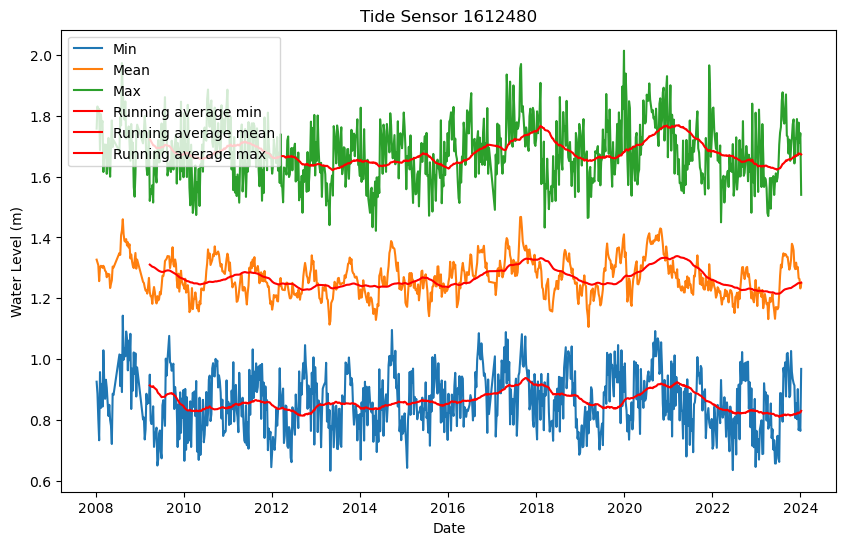

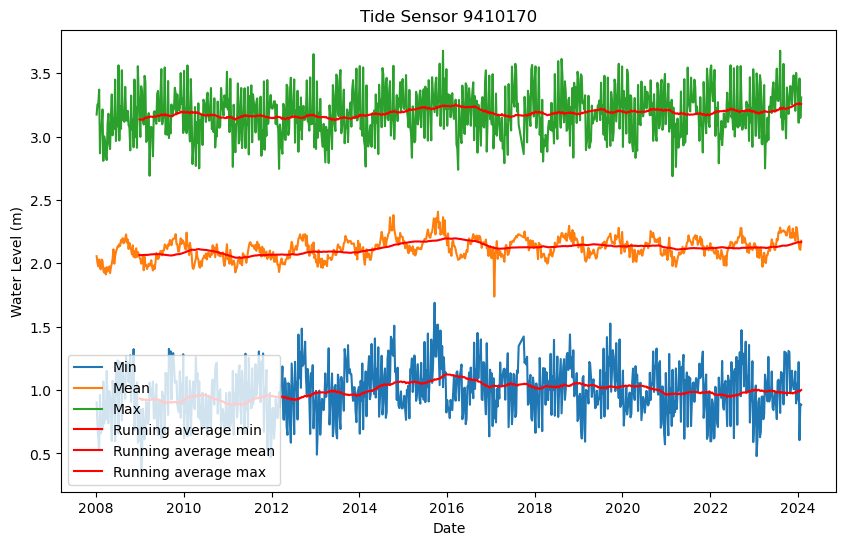

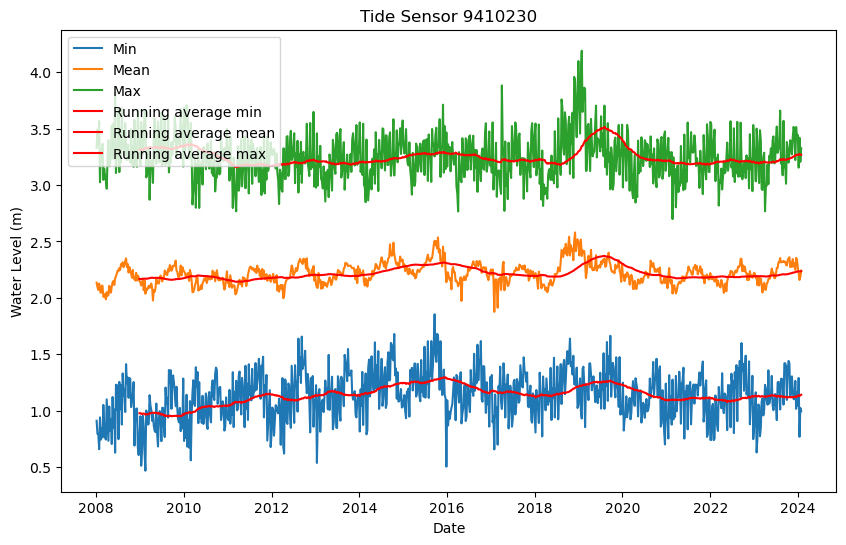

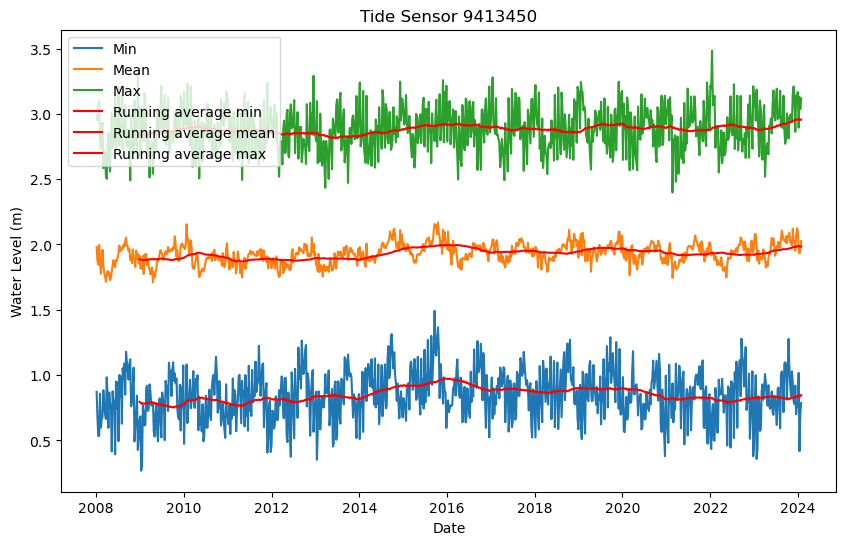

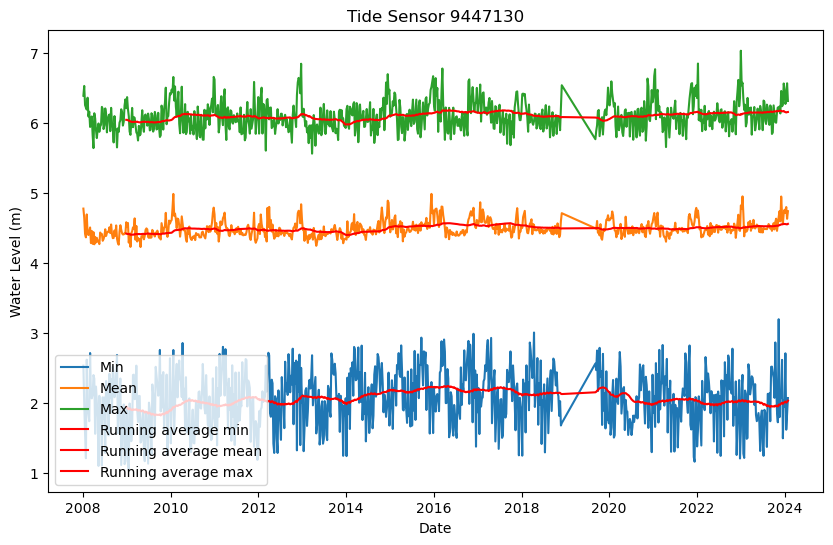

In [19]:
tide_sensor_data_cleaned_df = curate_tide_sensor_data(tide_sensor_data_df)

In [29]:
#def create_map(bases_df, sensors_df):

sensors_df = tide_sensors_df

"""
Creates a map with folium.

        Parameters:
                    Bases (DataFrame): Contains all US Bases that we want to see in the Map

        Returns:
                    None: 
"""

# folium Map centered on Glasgow Hall
nps_lat = 36.598802
nps_lon = -121.877178

# Create a map object
# Specify center location, and starting zoom level (0 to 18)
map = folium.Map(location=[nps_lat, nps_lon], zoom_start = 4, control_scal = True, tiles = "Cartodb Positron")

# Add a marker for Glasgow Hall
coord_list_bases = bases_df.geoPoint
cod_list_sensors = sensors_df.geoPoint

# Create popups
popups_bases = ['<b>Base:</b><br>{}<br><b>Altitude:</b><br>{}'.format(name, elevation) for (name, elevation) in bases_df[['name', 'elevation']].values]
popups_sensors = ['<b>Name:</b><br>{}'.format(name) for (name) in sensors_df['Location Name'].values]

# Create a MarkerCluster object for bases
marker_cluster_bases = MarkerCluster(
    locations = coord_list_bases,
    popups = popups_bases,
    name='US Bases',
    color='green',
    overlay=True,
    control=True
)

# Create a MarkerCluster object for sensors
marker_cluster_sensors = MarkerCluster(
    locations = cod_list_sensors,
    popups = popups_sensors,
    name='Tide Sensors',
    color='blue',
    overlay=True,
    control=True
)

# Add MarkerCluster to map
marker_cluster_bases.add_to(map)
marker_cluster_sensors.add_to(map)

folium.LayerControl().add_to(map)

# Save the map    
map.save('horbourTide.html')

map  

In [18]:
#def create_map2(bases_df, tide_sensors_df):

#John Berner

sensors_df = tide_sensors_df

"""
Creates a map with folium.

        Parameters:
                    Bases (DataFrame): Contains all US Bases that we want to see in the Map

        Returns:
                    None: 
"""

# folium Map centered on Glasgow Hall
nps_lat = 36.598802
nps_lon = -121.877178

# Create a map object
# Specify center location, and starting zoom level (0 to 18)
map2 = folium.Map(location=[nps_lat, nps_lon], zoom_start = 4, control_scal = True, tiles = "Cartodb Positron")

# Add a marker for Glasgow Hall
coord_list_bases = bases_df.geoPoint
coord_list_sensors = sensors_df.geoPoint

marker_cluster_bases = MarkerCluster(name='US Bases').add_to(map2)
marker_cluster_sensors = MarkerCluster(name='Tidal Sensors').add_to(map2)

# Create popups
popups_bases = ['<b>Base:</b><br>{}<br><b>Altitude:</b><br>{}'.format(name, elevation) for (name, elevation) in bases_df[['name', 'elevation']].values]
popups_sensors = ['<b>Name:</b><br>{}'.format(name) for (name) in sensors_df['Location Name'].values]

for coord, popup in zip(coord_list_bases, popups_bases):
    folium.Marker(location=coord, popup=popup, icon=folium.Icon('red')).add_to(marker_cluster_bases)

for sensor, popup in zip(coord_list_sensors, popups_sensors):
    folium.Marker(location=sensor, popup=popup, icon=folium.Icon('blue')).add_to(marker_cluster_sensors)


# Add MarkerCluster to map
marker_cluster_bases.add_to(map2)
marker_cluster_sensors.add_to(map2)

folium.LayerControl().add_to(map2)

# Save the map    
map2.save('horbourTide2.html')

map2  

In [30]:
tide_sensor_data_df.tail()


,datetime [ISO8601],waterlevel_quality_controlled [m],NOS ID
7877589,2024-01-28 23:55:00+00:00,5.137,9447130
7877590,2024-01-28 23:56:00+00:00,5.142,9447130
7877591,2024-01-28 23:57:00+00:00,5.146,9447130
7877592,2024-01-28 23:58:00+00:00,5.153,9447130
7877593,2024-01-28 23:59:00+00:00,5.159,9447130


In [31]:
tide_sensor_data_df.head()


,datetime [ISO8601],waterlevel_quality_controlled [m],NOS ID
0,2008-01-01 00:00:00+00:00,1.0995,1612480
1,2008-01-01 00:01:00+00:00,1.1005,1612480
2,2008-01-01 00:02:00+00:00,1.0995,1612480
3,2008-01-01 00:03:00+00:00,1.0975,1612480
4,2008-01-01 00:04:00+00:00,1.0975,1612480


In [32]:
tide_sensor_data_df.describe()

,waterlevel_quality_controlled [m],NOS ID
count,5.600855e+07,5.600855e+07
mean,2.730897e+01,8.311999e+06
std,4.972115e+02,2.728633e+06
min,-1.085000e+00,1.612480e+06
25%,1.571000e+00,9.410170e+06
50%,2.269000e+00,9.413450e+06
75%,3.189000e+00,9.446484e+06
max,9.999000e+03,9.447130e+06


In [33]:
tide_sensor_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56008550 entries, 0 to 7877593
Data columns (total 3 columns):
 #   Column                             Dtype              
---  ------                             -----              
 0   datetime [ISO8601]                 datetime64[ns, UTC]
 1   waterlevel_quality_controlled [m]  float64            
 2   NOS ID                             int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 1.7 GB
